In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import numpy as np
import json
import math
import torch
import numpy
import pandas
import argparse

from IPython import embed
from common.dataloader import load_SMD_dataset
from common import scikit_wrappers
from common.sliding import BatchSlidingWindow
%matplotlib inline

In [2]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [5]:
output_folder = '../datasets/SMD/processed'
with open(os.path.join(output_folder, "machine-1-1_test.pkl"), "rb") as fr:
    sample_data = pkl.load(fr)
with open(os.path.join(output_folder, "machine-1-1_test_label.pkl"), "rb") as fr:
    label = pkl.load(fr)
print(sample_data.shape)


(28479, 38)


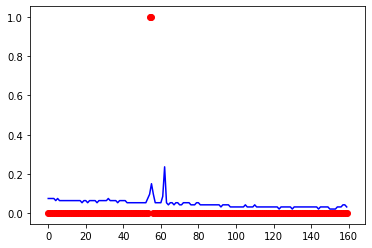

In [9]:
dim = 0
start = 27500
end = 27660
draw_data = sample_data[start:end, :]
draw_label = label[start:end]
x = np.array(range(draw_data.shape[0]))
y = draw_data[:, dim]
plt.plot(x,y,color='b')
plt.scatter(x,draw_label,color='r')

# 验证representation

In [10]:
def plot_window(window, x=None, dim=0, label="", color="b", legend=True):
    if not x:
        x = np.array(range(window.shape[1]))
    y = window[dim, :]
    plt.plot(x,y,color=color, label=label)
    if legend:
        plt.legend()

In [11]:
args = {}
args["dataset"] = "machine-1-1"
args["path"] = "../datasets/SMD/processed"
args["save_path"] = "../checkpoints"
args["gpu"] = "cpu"
args["hyper"] = "default_hyperparameters.json"

In [50]:
(train, _,), (test, test_labels) = load_SMD_dataset(args["path"], args["dataset"], use_dim=0)

In [95]:
# load pretrained model
encoder = scikit_wrappers.CausalCNNEncoder()
hf = open("../default_hyperparameters.json", 'r')
hp_dict = json.load(hf)
hf.close()
hp_dict['device'] = torch.device("cpu")
hp_dict['in_channels'] = train.shape[1]
encoder.set_params(**hp_dict)
encoder.load_encoder(os.path.join(args["save_path"], "test"))

In [96]:
test_sample = test[20000:]

In [97]:
# generate test_sample windows and encode them
from sklearn import manifold
window_size = 45
batch_size = 1000
test_windows_batcher = BatchSlidingWindow(test_sample.shape[0],
                                          window_size=window_size,
                                          batch_size=batch_size, shuffle=False)
features = encoder.encode(test_windows_batcher, test_sample, batch_size=batch_size)
test_windows = test_windows_batcher.get_windows(test_sample)
print(test_sample.shape, features.shape, test_windows.shape)

(8479, 1) torch.Size([8435, 300]) torch.Size([8435, 1, 45])


In [98]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=502)
X_tsne = tsne.fit_transform(features)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化

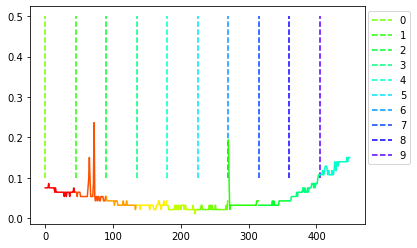

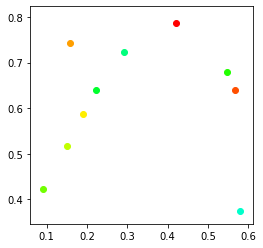

In [123]:
n_window = 10
start_window=7490
cmap = get_cmap(2*n_window)
ploted_windows = []
for i in range(n_window):
    w = test_windows[start_window + i*window_size, :, :]
    plot_window(w, x=range(window_size*i,window_size*(i+1)), color=cmap(i), legend=False)
    plt.vlines(window_size*i, 0.1, 0.5, label=i, colors = cmap(i+5), linestyles = "dashed")
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

    
plt.figure(figsize=(4, 4))
for i in range(n_window):
    w_idx = start_window+i*window_size
    reprentation = features[w_idx]
    plt.scatter(X_norm[w_idx, 0], X_norm[w_idx, 1], color=cmap(i))
    ploted_windows.append(reprentation)

In [127]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(len(ploted_windows)-1):
#     dist = np.sqrt(sum((ploted_windows[i].reshape(-1) - ploted_windows[i+1].reshape(-1))**2))
    dist = cosine_similarity(ploted_windows[i].reshape(1,-1), ploted_windows[i+1].reshape(1,-1))
#     dist = np.dot(ploted_windows[i], ploted_windows[i+1])
#     print(i, i+1, dist[0][0])
    print(round(dist[0][0],3))

0.59
0.354
0.994
0.997
0.998
0.58
0.604
0.94
0.316


#### 直接Plot降维后的曲线

0 1 0.345 0.59 0.224 0.885
1 2 0.503 0.354 0.283 0.872
2 3 0.076 0.994 0.065 0.971
3 4 0.05 0.997 0.073 0.957
4 5 0.037 0.998 0.047 0.96
5 6 0.465 0.58 0.203 0.803
6 7 0.413 0.604 0.183 0.807
7 8 0.198 0.94 0.235 0.99
8 9 0.413 0.316 0.393 0.989


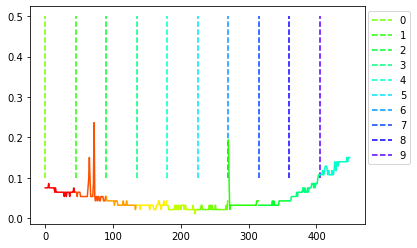

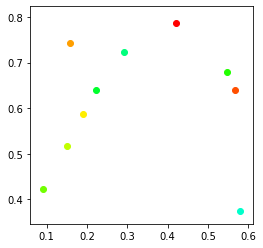

In [155]:
n_window = 10
start_window=7490
cmap = get_cmap(2*n_window)
ploted_windows = []
ploted_raw = []
for i in range(n_window):
    w = test_windows[start_window + i*window_size, :, :]
    plot_window(w, x=range(window_size*i,window_size*(i+1)), color=cmap(i), legend=False)
    plt.vlines(window_size*i, 0.1, 0.5, label=i, colors = cmap(i+5), linestyles = "dashed")
    ploted_raw.append(w)
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

    
plt.figure(figsize=(4, 4))
for i in range(n_window):
    w_idx = start_window+i*window_size
    reprentation = features[w_idx]
    plt.scatter(X_norm[w_idx, 0], X_norm[w_idx, 1], color=cmap(i))
    ploted_windows.append(reprentation)
    
from sklearn.metrics.pairwise import cosine_similarity
type_dists = [[],[],[],[]] 
for i in range(len(ploted_windows)-1):
    dist_l2 = np.sqrt(sum((ploted_windows[i].reshape(-1) - ploted_windows[i+1].reshape(-1))**2)).item()
    dist_cos = cosine_similarity(ploted_windows[i].reshape(1,-1), ploted_windows[i+1].reshape(1,-1))[0][0]
    dist_raw_cos = cosine_similarity(ploted_raw[i].reshape(1,-1), ploted_raw[i+1].reshape(1,-1))[0][0]
    dist_raw_l2 = np.sqrt(sum((ploted_raw[i].reshape(-1) - ploted_raw[i+1].reshape(-1).reshape(-1))**2)).item()
    type_dists[0].append(dist_l2)
    type_dists[1].append(dist_cos)
    type_dists[2].append(dist_raw_l2)
    type_dists[3].append(dist_raw_cos)        
#     dist = np.dot(ploted_windows[i], ploted_windows[i+1])
#     print(i, i+1, dist[0][0])
    print(i, i+1, round(dist_l2, 3), round(dist_cos,3), round(dist_raw_l2, 3), round(dist_raw_cos,3))

In [183]:
df = pd.DataFrame(np.array(type_dists), index=["repr_l2", "repr_cos", "raw_l2", "raw_cos"])

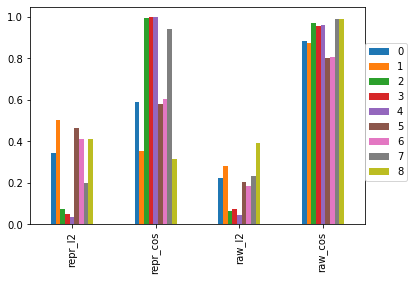

In [185]:
ax = df.plot.bar()
ax.legend(loc=(1,0.2)) 